# A. Creating Spark Session and Loading the Data

## Step 01:  Import Spark Session and initialize Spark

In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL


# local[4]: run Spark locally with 4 working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
sc = SparkContext(master="local[4]", appName="Predict rain tomorrow in Australia")
spark = SparkSession(sparkContext=sc)

## Step 02:  Load the dataset and print the schema and total number of entries

In [2]:
#spark.read.csv() is used to load data as CSV format
rain_df = spark.read.csv('weatherAUS.csv', header=True, inferSchema=True)

#count() is used to count the total number of entries in the dataset
rain_df.count()

142193

# B. Data Cleaning and Processing

## Step 03: Delete columns from the dataset

In [3]:
#create a list to store the columns that need to be deleted
columns_to_drop = ['Date', 'Location', 'Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

#use drop() to delete the columns that need to be deleted
rain_df = rain_df.drop(*columns_to_drop)
rain_df.show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

## Step 04: Print the number of missing data in each column.

In [4]:
# use for loop to iterate the columns of dataframe
# use filter to select the rows contain NA values
# use count to print the number of  NA values in each column
for col in rain_df.columns:
    na_values = rain_df.filter(rain_df[col] == 'NA')
    print(col, na_values.count())

MinTemp 637
MaxTemp 322
Rainfall 1406
WindGustDir 9330
WindGustSpeed 9270
WindDir9am 10013
WindDir3pm 3778
WindSpeed9am 1348
WindSpeed3pm 2630
Humidity9am 1774
Humidity3pm 3610
Pressure9am 14014
Pressure3pm 13981
RainToday 1406
RainTomorrow 0


## Step 05: Fill the missing data with average value and maximum occurrencevalue

In [5]:
rain_df.show(5)

# Since the first line of the data does not contain NAs, it can be used to identify numerical and 
# non-numerical columns

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

In [6]:
from pyspark.sql import functions
from pyspark.sql.functions import avg


#In order to identify numerica and non-numerica columns, we need to 
#firstly transfer the data in each column to int and check whether
#the isNotNull() function returns True(just check the first row to 
#reduce cost by using data[0][0]), if True that means the column is 
#numerica, if False that means the column is non-numerica.

for col in rain_df.columns:    
    data = rain_df.select(functions.col(col).cast('int').isNotNull()).collect()
    
    #For numerica columns, use avg() to calculate the average value and
    #use na.replace() to replace NAs
    if data[0][0]:
        average = rain_df.select(avg(col)).head()[0]
        rain_df = rain_df.na.replace('NA', str(average), col)
    
    #For non-numerica columns, use map(),reduceByKey and sortBy()
    #to calculate the occurance of each words in descending, then
    #use toDF() to transfer to DataFrame
    else:
        frequents = rain_df.select(col).rdd.map(lambda x: (x,1)) \
                    .reduceByKey(lambda x,y: x+y) \
                    .sortBy(lambda x: x[1], ascending = False) \
                    .toDF()
        
        #select the head and since the first item in the list is a list,
        #to get the word, use head()[0][0]
        frequent = frequents.select('_1').head()[0][0]
        rain_df = rain_df.na.replace('NA', frequent, col)
                    


In [7]:
rain_df.show()
#Now all the NAs are replaced

+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|               0.6|          W|           44|         W|       WNW|             20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|                 0|        WNW|           44|       NNW|       WSW|              4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|                 0|        WSW|           46|         W|  

## Step 06: Data transformation

In [8]:
from pyspark.ml.feature import StringIndexer


for col in rain_df.columns:    
    data = rain_df.select(functions.col(col).cast('double').isNotNull()).collect()
    
    #numerica
    if data[0][0]:
        #use withColumn to alternate original column with double version
        rain_df = rain_df.withColumn(col, functions.col(col).cast('double'))
        
    
    #non-numerica
    #use StringIndexer to fit non-numerica columns to numbers
    else:
        col_num = col+'_num'
        num_StringIndexer = StringIndexer(inputCol = col, outputCol = col_num)       
        model = num_StringIndexer.fit(rain_df)       
        rain_df = model.transform(rain_df)        
        #drop the original non-numerica data
        rain_df = rain_df.drop(col)
        
rain_df.show()

+-------+-------+------------------+-------------+---------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+----------------+
|MinTemp|MaxTemp|          Rainfall|WindGustSpeed|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_num|WindDir9am_num|WindDir3pm_num|RainToday_num|RainTomorrow_num|
+-------+-------+------------------+-------------+---------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+----------------+
|   13.4|   22.9|               0.6|         44.0|           20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|            0.0|           6.0|           7.0|          0.0|             0.0|
|    7.4|   25.1|               0.0|         44.0|            4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|            9.0|           9.0|           3.0|       

## Step 07: Create the feature vector and divide the dataset

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#exclude 'RainTomorrow_num' as column to test accuracy
inputCols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', \
            'Pressure9am', 'Pressure3pm', 'WindGustDir_num', 'WindDir9am_num', 'WindDir3pm_num', 'RainToday_num']
#create feature vector
vector_assembler = VectorAssembler(\
inputCols=inputCols,\
outputCol='features')

df_temp = vector_assembler.transform(rain_df)
df_temp.show(3)

#remain just RainTpmorrow_num and features columns
rain_df = df_temp.select('RainTomorrow_num','features')
rain_df.show(3)


(trainingData, testData) = rain_df.randomSplit([0.7, 0.3], seed = 1996)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+----------------+--------------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir_num|WindDir9am_num|WindDir3pm_num|RainToday_num|RainTomorrow_num|            features|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+---------------+--------------+--------------+-------------+----------------+--------------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|            0.0|           6.0|           7.0|          0.0|             0.0|[13.4,22.9,0.6,44...|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|            9.0|           9.0|   

# C. Apply Machine Learning Algorithms

## Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph

### 1. Run and calculate the accuracy of decision tree algorithm using DecisionTreeClassifier()

In [10]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="RainTomorrow_num", featuresCol="features")
model = dt.fit(trainingData)

prediction_dt = model.transform(testData)

prediction_dt.select("prediction", "RainTomorrow_num").show(10)

evaluator = MulticlassClassificationEvaluator(\

labelCol="RainTomorrow_num", predictionCol="prediction",\

metricName="accuracy")

accuracy1 = evaluator.evaluate(prediction_dt)

print("Accuracy = ", accuracy1)
print("Test Error = %g " % (1.0 - accuracy1))

+----------+----------------+
|prediction|RainTomorrow_num|
+----------+----------------+
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       1.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
+----------+----------------+
only showing top 10 rows

Accuracy =  0.8350025740628071
Test Error = 0.164997 


### 2. Run and calculate the accuracy of random forest algorithm using RandomForestClassifier()

In [11]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="RainTomorrow_num",\
featuresCol="features", numTrees=10)

model = rf.fit(trainingData)

prediction_rf = model.transform(testData)

prediction_rf.select("prediction", "RainTomorrow_num").show(10)

evaluator =\
MulticlassClassificationEvaluator(labelCol="RainTomorrow_num",\
predictionCol="prediction", metricName="accuracy")

accuracy2 = evaluator.evaluate(prediction_rf)

print("Accuracy = ", accuracy2)
print("Test Error = %g" % (1.0 - accuracy2))

+----------+----------------+
|prediction|RainTomorrow_num|
+----------+----------------+
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       1.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
+----------+----------------+
only showing top 10 rows

Accuracy =  0.8324051106847007
Test Error = 0.167595


### 3. Run and calculate the accuracy using LogisticRegression()

In [12]:
from pyspark.ml.classification import LogisticRegression

# Create an initial model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrow_num',    maxIter=10)
lrModel = lr.fit(trainingData)

prediction_lr = lrModel.transform(testData)
prediction_lr.select("prediction", "RainTomorrow_num").show(10)

evaluator = MulticlassClassificationEvaluator(\

labelCol="RainTomorrow_num", predictionCol="prediction",\

metricName="accuracy")

accuracy3 = evaluator.evaluate(prediction_lr)

print("Accuracy = ", accuracy3)
print("Test Error = %g " % (1.0 - accuracy3))

+----------+----------------+
|prediction|RainTomorrow_num|
+----------+----------------+
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
+----------+----------------+
only showing top 10 rows

Accuracy =  0.8130060373473113
Test Error = 0.186994 


### 4. Run and calculate the accuracy using GbTClassifier()

In [13]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'RainTomorrow_num', maxIter=10)
gbtModel = gbt.fit(trainingData)
prediction_gbt = gbtModel.transform(testData)
prediction_gbt.select("prediction", "RainTomorrow_num").show(10)

evaluator = MulticlassClassificationEvaluator(\

labelCol="RainTomorrow_num", predictionCol="prediction",\

metricName="accuracy")

accuracy4 = evaluator.evaluate(prediction_gbt)

print("Accuracy = ", accuracy4)
print("Test Error = %g " % (1.0 - accuracy4))

+----------+----------------+
|prediction|RainTomorrow_num|
+----------+----------------+
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       1.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
|       0.0|             0.0|
+----------+----------------+
only showing top 10 rows

Accuracy =  0.839167875696167
Test Error = 0.160832 


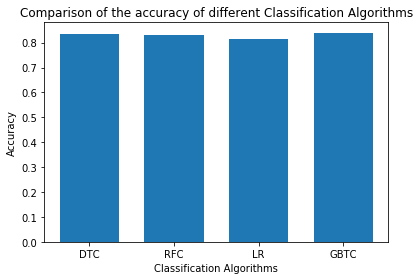

In [14]:
import numpy as np
#!pip install matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

x = ['DTC', 'RFC', 'LR', 'GBTC']
y = [accuracy1, accuracy2, accuracy3, accuracy4]


bar_width = 0.7

y_pos = np.arange(len(x))

plt.bar(y_pos, y, bar_width, align='center')
plt.xticks(y_pos, x)
plt.xlabel('Classification Algorithms')
plt.ylabel('Accuracy')
plt.title('Comparison of the accuracy of different Classification Algorithms')
plt.tight_layout()
plt.show()


BY the comparison we can find that the accuracy of the four algorithms are all around 80 percents.

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?

### Decision Tree

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

#!pip install pandas
import pandas as pd
import numpy as np

predictionAndLabels = prediction_dt.rdd.map(lambda x: (x.prediction, \
                                       x.RainTomorrow_num))

metrics = MulticlassMetrics(predictionAndLabels)

temp_cm = metrics.confusionMatrix().toArray().tolist()

data_cm = np.array([['','Predict_Positive','Predict_Negative'],\
                ['Actual_Positive',temp_cm[0][0],temp_cm[0][1]],\
                ['Actual_Negative',temp_cm[1][0],temp_cm[1][1]]])
#The confusion matrix format is TP, FN
#                               FP, TN

dt_cm = pd.DataFrame(data=data_cm[1:,1:],\
                  index=data_cm[1:,0],\
                  columns=data_cm[0,1:])
print("\nConfusion Matrix:")
print(dt_cm)

TP = temp_cm[0][0]
FN = temp_cm[0][1]
FP = temp_cm[1][0]
TN = temp_cm[1][1]

precisionDT = TP / (TP + FP)
recallDT = TP / (TP + FN)
f1DT = (2 * precisionDT * recallDT) / (precisionDT + recallDT)
print('precision:', precisionDT)
print('recall:', recallDT)
print('f1:', f1DT)

### Random Forest

In [ ]:
predictionAndLabels = prediction_rf.rdd.map(lambda x: (x.prediction, \
                                       x.RainTomorrow_num))

metrics = MulticlassMetrics(predictionAndLabels)

temp_cm = metrics.confusionMatrix().toArray().tolist()

data_cm = np.array([['','Predict_Positive','Predict_Negative'],\
                ['Actual_Positive',temp_cm[0][0],temp_cm[0][1]],\
                ['Actual_Negative',temp_cm[1][0],temp_cm[1][1]]])
#The confusion matrix format is TP, FN
#                               FP, TN

dt_cm = pd.DataFrame(data=data_cm[1:,1:],\
                  index=data_cm[1:,0],\
                  columns=data_cm[0,1:])
print("\nConfusion Matrix:")
print(dt_cm)

TP = temp_cm[0][0]
FN = temp_cm[0][1]
FP = temp_cm[1][0]
TN = temp_cm[1][1]

precisionRF = TP / (TP + FP)
recallRF = TP / (TP + FN)
f1RF = (2 * precisionRF * recallRF) / (precisionRF + recallRF)
print('precision:', precisionRF)
print('recall:', recallRF)
print('f1:', f1RF)

### Logistic Regression

In [ ]:
predictionAndLabels = prediction_lr.rdd.map(lambda x: (x.prediction, \
                                       x.RainTomorrow_num))

metrics = MulticlassMetrics(predictionAndLabels)

temp_cm = metrics.confusionMatrix().toArray().tolist()

data_cm = np.array([['','Predict_Positive','Predict_Negative'],\
                ['Actual_Positive',temp_cm[0][0],temp_cm[0][1]],\
                ['Actual_Negative',temp_cm[1][0],temp_cm[1][1]]])
#The confusion matrix format is TP, FN
#                               FP, TN

dt_cm = pd.DataFrame(data=data_cm[1:,1:],\
                  index=data_cm[1:,0],\
                  columns=data_cm[0,1:])
print("\nConfusion Matrix:")
print(dt_cm)

TP = temp_cm[0][0]
FN = temp_cm[0][1]
FP = temp_cm[1][0]
TN = temp_cm[1][1]

precisionLR = TP / (TP + FP)
recallLR = TP / (TP + FN)
f1LR = (2 * precisionLR * recallLR) / (precisionLR + recallLR)
print('precision:', precisionLR)
print('recall:', recallLR)
print('f1:', f1LR)

### GBT

In [ ]:
predictionAndLabels = prediction_gbt.rdd.map(lambda x: (x.prediction, \
                                       x.RainTomorrow_num))

metrics = MulticlassMetrics(predictionAndLabels)

temp_cm = metrics.confusionMatrix().toArray().tolist()

data_cm = np.array([['','Predict_Positive','Predict_Negative'],\
                ['Actual_Positive',temp_cm[0][0],temp_cm[0][1]],\
                ['Actual_Negative',temp_cm[1][0],temp_cm[1][1]]])
#The confusion matrix format is TP, FN
#                               FP, TN

dt_cm = pd.DataFrame(data=data_cm[1:,1:],\
                  index=data_cm[1:,0],\
                  columns=data_cm[0,1:])
print("\nConfusion Matrix:")
print(dt_cm)

TP = temp_cm[0][0]
FN = temp_cm[0][1]
FP = temp_cm[1][0]
TN = temp_cm[1][1]

precisionGBTC = TP / (TP + FP)
recallGBTC = TP / (TP + FN)
f1GBTC = (2 * precisionGBTC * recallGBTC) / (precisionGBTC + recallGBTC)
print('precision:', precisionGBTC)
print('recall:', recallGBTC)
print('f1:', f1GBTC)

## How the accuracy of the predication can be improved

In order to improve accuracy of the predication, we should reduce the FP and FN in the confusion matrix, which can be done by filtering abnormal records in the dataset(because these abnormal records are in high posibility of leading matchine learning to do wrong training), for example, remove the records that contain NAs.